In [1]:
import os
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plot
from matplotlib.colors import LogNorm

from pyuvdata import UVBeam


In [2]:
lwa_beam_file = "/Users/bryna/Projects/Physics/data_files/lwa_beam_testing/LWAbeam_2015.fits"

In [3]:
efield_beam = UVBeam.from_file(lwa_beam_file, beam_type='efield')

In [4]:
print(np.min(efield_beam.axis1_array), np.max(efield_beam.axis1_array))
print(np.min(efield_beam.axis2_array), np.max(efield_beam.axis2_array))

0.0 6.19591884457987
0.08726646259971647 1.5707963267948966


In [5]:
basis_axis_index = 0
feed_index = 0
freq_index = 0

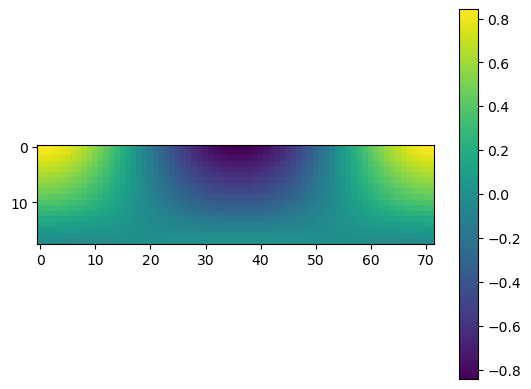

In [6]:
plot.imshow(efield_beam.data_array[basis_axis_index, feed_index, freq_index, :].real)
plot.colorbar()

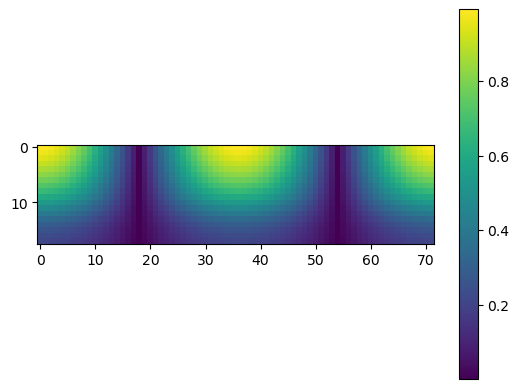

In [7]:
plot.imshow(np.abs(efield_beam.data_array[basis_axis_index, feed_index, freq_index, :]))
plot.colorbar()

In [8]:
zenith_patch_theta_inds = np.where(efield_beam.axis2_array <= np.deg2rad(20.))

In [9]:
zenith_patch_theta_inds

(array([0, 1, 2, 3]),)

In [10]:
zenith_patch_phi_vals, zenith_patch_theta_vals = np.meshgrid(
    efield_beam.axis1_array,
    efield_beam.axis2_array[np.where(efield_beam.axis2_array <= np.deg2rad(5.))])

In [11]:
tangent_x_vals = np.sin(zenith_patch_theta_vals) * np.cos(zenith_patch_phi_vals)
tangent_y_vals = np.sin(zenith_patch_theta_vals) * np.sin(zenith_patch_phi_vals)


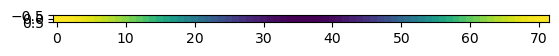

In [12]:
plot.imshow(tangent_x_vals)


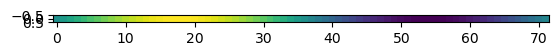

In [13]:
plot.imshow(tangent_y_vals)

# pretty beam image

Now define a regular grid in direction cosines (l, m) then
turn those into az,za and interpolate to them so we can
make a nice top down image of the beam

In [14]:
grid_pix = 101
lm_vec, delta_lm = np.linspace(-1,1,num=grid_pix, retstep=True)
mgrid, lgrid = np.meshgrid(lm_vec, lm_vec)

In [15]:
ngrid = np.sqrt(1 - lgrid**2. - mgrid**2.)

invalid value encountered in sqrt


In [16]:
ngrid_ma = np.ma.masked_where(~np.isfinite(ngrid), ngrid)
mgrid_ma = np.ma.masked_where(~np.isfinite(ngrid), mgrid)
lgrid_ma = np.ma.masked_where(~np.isfinite(ngrid), lgrid)

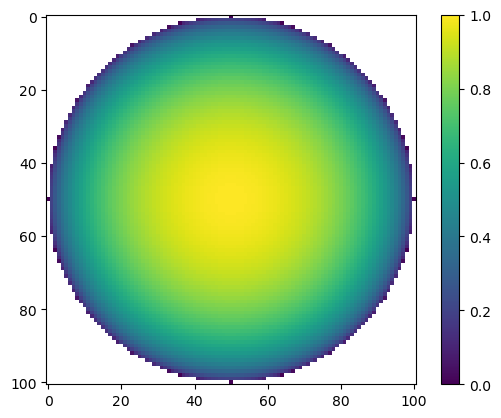

In [17]:
plot.imshow(ngrid_ma)
plot.colorbar()

In [18]:
za_ma = np.arccos(ngrid_ma)

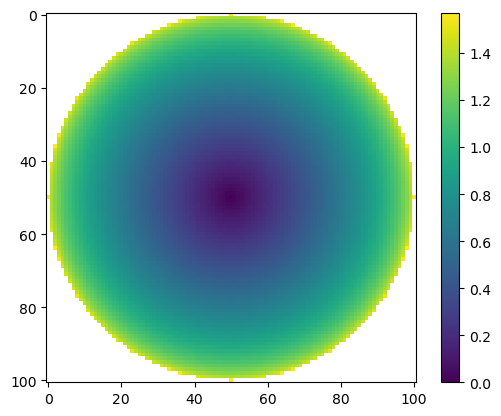

In [19]:
plot.imshow(za_ma)
plot.colorbar()

In [20]:
az_ma = -1*np.atan2(lgrid_ma, mgrid_ma)
az_ma[az_ma < 0] += 2*np.pi

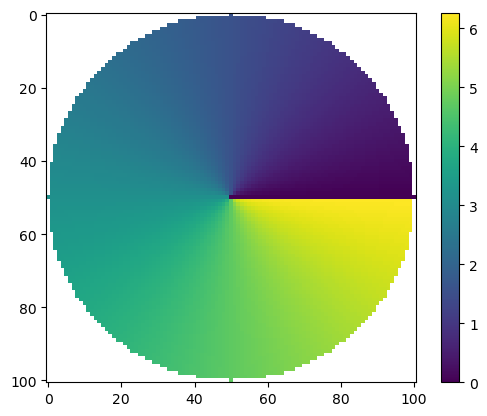

In [21]:
plot.imshow(az_ma)
plot.colorbar()

In [22]:
interp_beam_vals, _ = efield_beam.interp(
    az_array = az_ma.compressed(),
    za_array = za_ma.compressed(),
)

In [23]:
interp_beam = np.zeros_like(az_ma, dtype="complex")
interp_beam = np.expand_dims(interp_beam, axis=(0, 1, 2))
interp_beam.shape
interp_beam = np.repeat(interp_beam, efield_beam.Naxes_vec, axis=0)
interp_beam = np.repeat(interp_beam, efield_beam.Nfeeds, axis=1)
interp_beam = np.repeat(interp_beam, efield_beam.Nfreqs, axis=2)
for vec_i in range(efield_beam.Naxes_vec):
    for feed_i in range(efield_beam.Nfeeds):
        for freq_i in range(efield_beam.Nfreqs):
            interp_beam[vec_i, feed_i, freq_i, interp_beam[vec_i, feed_i, freq_i].mask == False] = interp_beam_vals[vec_i, feed_i, freq_i]

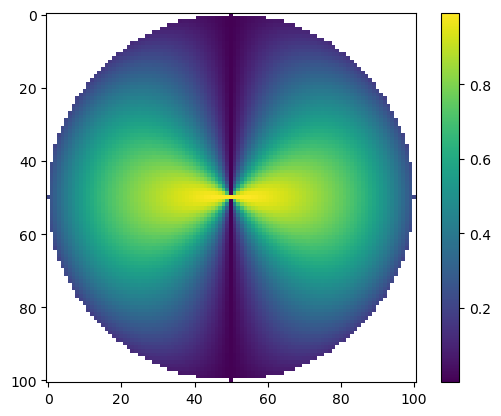

In [24]:
plot.imshow(np.abs(interp_beam[0,0,0]))
plot.colorbar()

In [25]:
single_beam = interp_beam[0,0,0].data
clip_ind = 15
clipped_beam = single_beam[clip_ind:-1*clip_ind,clip_ind:-1*clip_ind]

In [26]:
clipped_beam.shape

(71, 71)

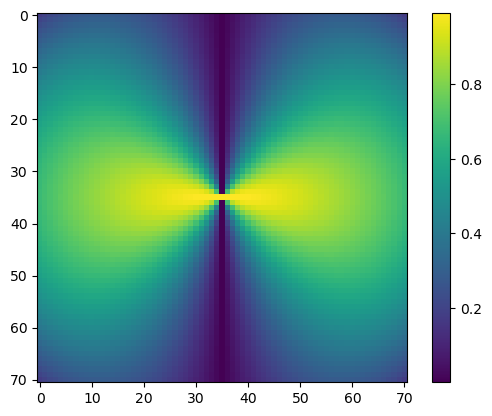

In [27]:
plot.imshow(np.abs(clipped_beam))
plot.colorbar()

In [28]:
np.where(np.abs(clipped_beam) == np.abs(clipped_beam).max())

(array([35, 35, 35, 35, 35]), array([35, 36, 37, 38, 39]))

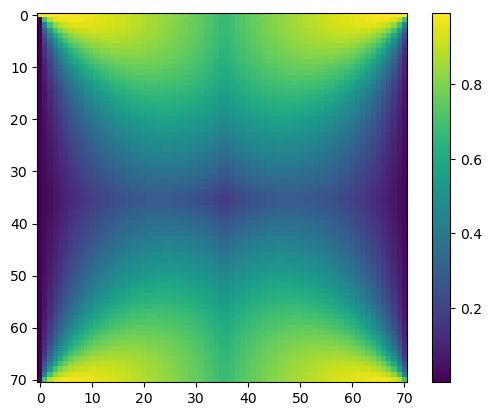

In [29]:
plot.imshow(np.abs(np.fft.ifftshift(clipped_beam)))
plot.colorbar()

In [30]:
np.where(np.abs(np.fft.ifftshift(clipped_beam))==np.abs(np.fft.ifftshift(clipped_beam).max()))

(array([0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4]))

In [31]:
uv_beam = np.fft.ifftshift(np.fft.fft2(np.fft.ifftshift(clipped_beam)))/(grid_pix-2*clip_ind)**2

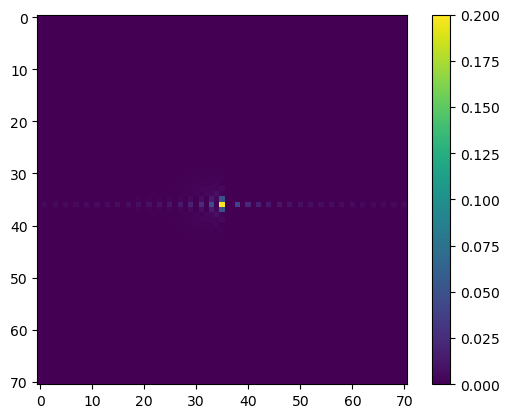

In [32]:
plot.imshow(np.real(uv_beam), vmin=0, vmax=.2)
plot.colorbar()

In [33]:
mask = np.zeros_like(uv_beam, dtype=float)
mask[np.abs(uv_beam)>1e-1]=1.

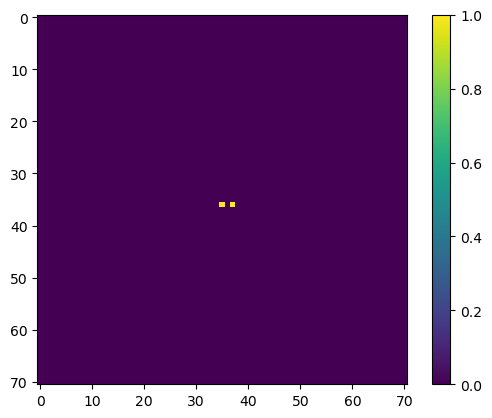

In [34]:
plot.imshow(mask)
plot.colorbar()

In [35]:
sd_beam = np.zeros_like(az_ma, dtype="complex")
sd_beam[sd_beam.mask == False] = -1 * np.sin(az_ma.compressed())

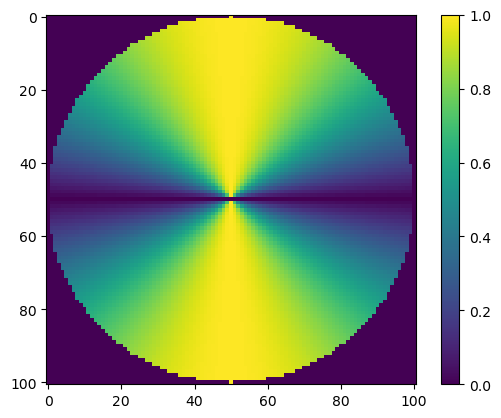

In [36]:
plot.imshow(np.abs(sd_beam.data))
plot.colorbar()